In [1]:
!date

Fri Jan 15 13:31:32 PST 2021


# Notebook for developing the comparisons between kallisto-bustools and salmon-alevin-fry 

In [1]:
from kb_python.utils import import_matrix_as_anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib

### Import cellranger barcodes as "ground truth barcodes"

In [3]:
ds = "human-pbmc10k_v3"
ref = "human-grch38"

In [4]:
cellranger_barcodes_file = f"../../data/cellranger_barcodes/{ds}.txt"
c = pd.read_csv(cellranger_barcodes_file, header=None, names=['bcs'])
c = c.bcs.apply(lambda x: x.split('-')[0]).values

# load whitelists
kb_wl_file = f"../../data/kallisto_out/{ds}/whitelist.txt"    
al_wl_file = f"../../data/alevin_out/{ds}/whitelist/permit_freq.tsv"

k = nd(pd.read_csv(kb_wl_file, header=None).values)
a = nd(pd.read_csv(al_wl_file, header=None, sep="\t", names = ['bcs', 'cnt'])['bcs'].values)

cr_barcodes = np.intersect1d(np.intersect1d(k, a), c)

## Import matrices

In [5]:
alevin_path = f"../../data/alevin_out/{ds}/quant/alevin/"
#alevin_path = "../../data/alevin_out/mouse-SRR8206317_v2/alevin-standard/alevin/"

alevin_raw_decoys = import_matrix_as_anndata(
    barcodes_path=os.path.join(alevin_path, "quants_mat_rows.txt"), 
    genes_path=os.path.join(alevin_path, "quants_mat_cols.txt"), 
    matrix_path=os.path.join(alevin_path, "quants_mat.mtx"))

In [6]:
alevin_raw_decoys

AnnData object with n_obs × n_vars = 1544083 × 33732

In [7]:
decoys = pd.read_csv(f"../../reference/{ref}/salmon/decoys.txt", header = None, names=['decoys'])

alevin_raw = alevin_raw_decoys[:, ~alevin_raw_decoys.var.index.isin(decoys['decoys'])].copy()

In [8]:
alevin_raw

AnnData object with n_obs × n_vars = 1544083 × 33538

In [9]:
kb_path = f"../../data/kallisto_out/{ds}/count/"

kb_raw = import_matrix_as_anndata(
    barcodes_path=os.path.join(kb_path, "output.barcodes.txt"), 
    genes_path=   os.path.join(kb_path, "output.genes.txt"), 
    matrix_path=  os.path.join(kb_path, "output.mtx"))

In [10]:
kb_raw

AnnData object with n_obs × n_vars = 1266268 × 33538

In [11]:
print(kb_raw.var.shape[0] - alevin_raw.var.shape[0])
print(False in kb_raw.var.index == alevin_raw.var.index)

print(kb_raw)
print(alevin_raw)

0
False
AnnData object with n_obs × n_vars = 1266268 × 33538
AnnData object with n_obs × n_vars = 1544083 × 33538


## Basic process

In [12]:
def basic_process(A):
    '''
    sum counts per cell
    count ngenes per cell
    filter out cells with zero genes
    '''
    adata = A.copy()
    adata.obs['counts'] = nd(adata.X.sum(axis=1))
    adata.obs['ngenes'] = nd((adata.X > 0).sum(axis=1))
    adata = adata[adata.obs['counts'] > 0]
    adata.layers['log1p'] = np.log1p(adata.X)
    print(adata)

    return adata

In [13]:
kb = basic_process(kb_raw)
alevin = basic_process(alevin_raw)

AnnData object with n_obs × n_vars = 1180558 × 33538
    obs: 'counts', 'ngenes'
    layers: 'log1p'
AnnData object with n_obs × n_vars = 1544083 × 33538
    obs: 'counts', 'ngenes'
    layers: 'log1p'


In [14]:
kb_barcodes = kb.obs.index.values
alevin_barcodes = alevin.obs.index.values

common_barcodes = np.intersect1d(kb_barcodes, alevin_barcodes)

# kb_barcodes_only = np.setdiff1d(kb_barcodes,alevin_barcodes)
# alevin_barcodes_only = np.setdiff1d(alevin_barcodes,kb_barcodes)

In [15]:
kb_genes = kb.var.index.values
alevin_genes = alevin.var.index.values

common_genes = np.intersect1d(kb_genes, alevin_genes)

# kb_genes_only = np.setdiff1d(kb_genes,alevin_genes)
# alevin_genes_only = np.setdiff1d(alevin_genes,kb_genes)

### Common matrices

In [16]:
kb_common = kb[common_barcodes][:, common_genes]
alevin_common = alevin[common_barcodes][:, common_genes]

In [17]:
print(kb_common)
print(alevin_common)

View of AnnData object with n_obs × n_vars = 1006362 × 33538
    obs: 'counts', 'ngenes'
    layers: 'log1p'
View of AnnData object with n_obs × n_vars = 1006362 × 33538
    obs: 'counts', 'ngenes'
    layers: 'log1p'


##### Olfactory foray

In [72]:
from scipy.io import mmread, mmwrite

In [73]:
tx_path = f"raw_feature_bc_matrix/"

In [75]:
mtx_T = mmread(os.path.join(tx_path, "matrix.mtx")).T

In [76]:
mmwrite(os.path.join(tx_path, "matrix_T.mtx"), mtx_T)

In [79]:
tx_raw = import_matrix_as_anndata(
    barcodes_path=os.path.join(tx_path, "barcodes.tsv"), 
    genes_path=   os.path.join(tx_path, "genes.txt"), 
    matrix_path=  os.path.join(tx_path, "matrix_T.mtx"))

In [85]:
tx_raw.obs.index = tx_raw.obs.index.str.slice(0, 16).values

In [90]:
tx_common = tx_raw[common_barcodes][:, common_genes]

In [36]:
def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

In [37]:
olf = [
"ENSG00000254466",
"ENSG00000177233",
"ENSG00000176798",
"ENSG00000204701",
"ENSG00000176299",
"ENSG00000182652",]

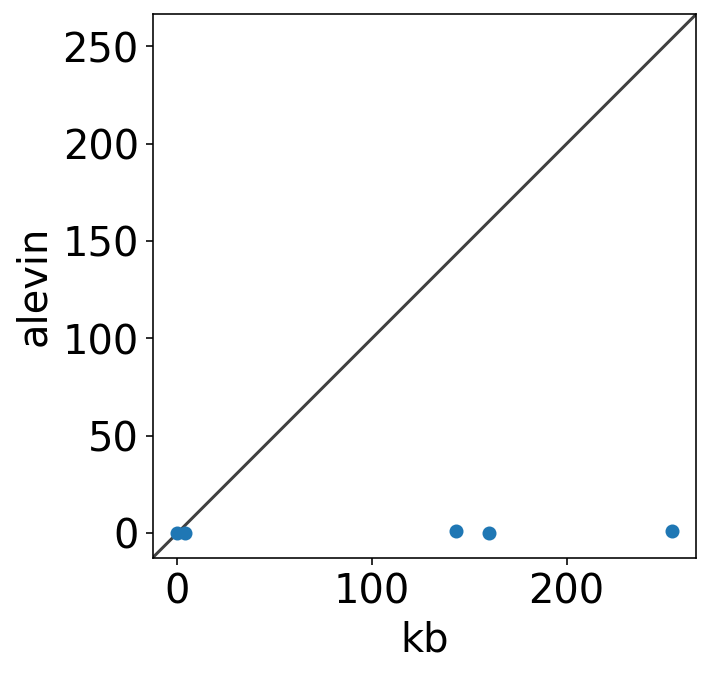

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
x = nd(kb_common.X[:,kb_common.var.index.isin(olf)].sum(axis=0))
y = nd(alevin_common.X[:,alevin_common.var.index.isin(olf)].sum(axis=0))

ax.scatter(x,y)
yex(ax)
ax.set(**{
    "xlabel": "kb",
    "ylabel": "alevin"
})

fig.show()

In [96]:
nd(tx_common.X[:,tx_common.var.index.isin(olf)].sum(axis=0))

array([0., 0., 1., 0., 0.], dtype=float32)

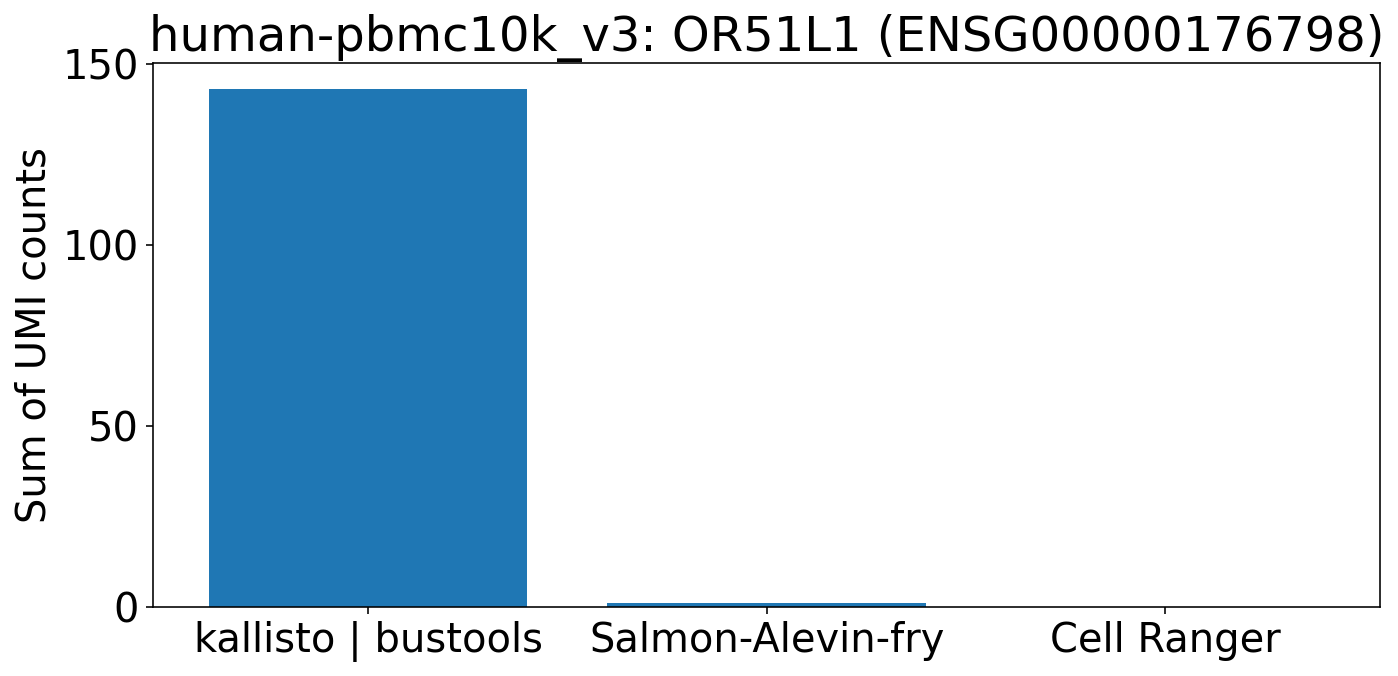

In [110]:
fig, ax = plt.subplots(figsize=(11,5))

y = [
    kb_common.X[:,kb_common.var.index == "ENSG00000176798"].sum(),
    alevin_common.X[:,alevin_common.var.index == "ENSG00000176798"].sum(),
    tx_common.X[:,tx_common.var.index == "ENSG00000176798"].sum()
]

ax.bar(["kallisto | bustools", "Salmon-Alevin-fry", "Cell Ranger"], y)
ax.set(**{
    "ylabel": "Sum of UMI counts",
    "title": f"{ds}: OR51L1 (ENSG00000176798)"
})

fig.show()

In [40]:
kb_common.var[kb_common.var.index.isin(olf)]

""
gene_id
ENSG00000176299
ENSG00000176798
ENSG00000182652
ENSG00000204701
ENSG00000254466


In [41]:
x

array([  4., 143., 254., 160.,   0.], dtype=float32)

In [42]:
alevin_common.var[alevin_common.var.index.isin(olf)]


""
gene_id
ENSG00000176299
ENSG00000176798
ENSG00000182652
ENSG00000204701
ENSG00000254466


In [43]:
y

array([0., 1., 1., 0., 0.], dtype=float32)

In [33]:
alevin_common.X[:,alevin_common.var.index.isin(olf)].sum(axis=0)

matrix([[0., 1., 1., 0., 0.]], dtype=float32)

In [29]:
y

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
kb_common_cr     = kb_common[cr_barcodes]
alevin_common_cr = alevin_common[cr_barcodes]

In [ ]:
print(kb_common_cr)
print(alevin_common_cr)

In [ ]:
False in kb_common_cr.obs.index.values == alevin_common_cr.obs.index.values

# Generate comparison results

#### MA data

In [ ]:
def MA(AX, BX):
    '''
        Computes MA for MA plot
        X: A.var["gene_count"]
        Y: B.var["gene_count"]
    '''
    X = nd(AX.mean(axis=0))
    Y = nd(BX.mean(axis=0))

    M_AB = np.log2(X + 1) - np.log2(Y + 1)
    A_AB = 0.5*(np.log2(X + 1) + np.log2(Y + 1))
    return A_AB, M_AB

In [ ]:
A_AB, M_AB = MA(kb_common_cr.X, alevin_common_cr.X)

#### Cell correlation data

In [24]:
# Correlations
def _sparse_M_std(X):
    n = X.shape[0]
    return np.sqrt(n * X.multiply(X).sum(0) - np.multiply(X.sum(0), X.sum(0)))

def sparse_M_corr(X, Y):
    '''
        Computes Pearson correlation between X and Y (both in sparse format). Must be same shape.
        X: A_raw[common_obs.index].layers['log1p'] # raw
        Y: B_raw[common_obs.index].layers['log1p']# raw
        X: A.layers['log1p'] # filtered
        Y: B.layers['log1p'] # filtered
        Notes: I changed the axis in sum and shape, need to check if right
    '''
    X_std = _sparse_M_std(X)
    Y_std = _sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[0]
    XY_cov = n*X.multiply(Y).sum(0) - np.multiply(X.sum(0), Y.sum(0))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

In [25]:
cc_raw = sparse_M_corr(
    kb_common.layers['log1p'].T, 
    alevin_common.layers['log1p'].T)

In [26]:
cc_filtered = sparse_M_corr(
    kb_common_cr.layers['log1p'].T, 
    alevin_common_cr.layers['log1p'].T)

#### TSVD and TSNE data

In [27]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

def compute_tsvd(X):
    tsvd = TruncatedSVD(n_components=10)
    Y = tsvd.fit_transform(X)
    return Y

def compute_tsne(X):
    tsne = TSNE(perplexity=30, metric="euclidean", n_jobs=10, random_state=42, n_iter=750 )
    Y = tsne.fit_transform(X)
    return Y

In [28]:
kb_common_cr.obsm['TSVD']     = compute_tsvd(kb_common_cr.layers['log1p'])
alevin_common_cr.obsm['TSVD'] = compute_tsvd(alevin_common_cr.layers['log1p'])

In [29]:
kb_common_cr.obsm['TSNE']     = compute_tsne(kb_common_cr.obsm['TSVD'])
alevin_common_cr.obsm['TSNE'] = compute_tsne(alevin_common_cr.obsm['TSVD'])

#### L1 cell-cell distance

In [30]:
from sklearn.metrics.pairwise import manhattan_distances

def l1_dist(X, Y):
    '''
    computes manhattan distance between corresponding cells, and nearest cells
        X: A.layers['log1p']
        Y: B.layers['log1p']
    '''
    dist_AA = manhattan_distances(X, X)
    dist_AB = manhattan_distances(X, Y)

    # nkc are the kallisto-alevin distances
    dist_AB = np.diagonal(dist_AB)

    # ncc are the kallisto-kallisto distances
    AA = []
    for row in dist_AA:
        val = np.partition(row, 1)[1]
        AA.append(val)
    dist_AA = AA

    return dist_AA, dist_AB


In [31]:
dist_AA, dist_AB = l1_dist(kb_common_cr.layers['log1p'], alevin_common_cr.layers['log1p'])
dist_BB, dist_BA = l1_dist(alevin_common_cr.layers['log1p'], kb_common_cr.layers['log1p'])

## Make plots

In [74]:
from matplotlib.ticker import LogLocator, NullFormatter
def fix_ticks(ax, axis=['x']):
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=25)
    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=25)
    if 'x' in axis:
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.xaxis.set_major_locator(locmaj)
    if 'y' in axis:
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(NullFormatter())
        ax.yaxis.set_major_locator(locmaj)
    return ax

In [32]:
markersize = 20
alpha=1
linewidth=5
xmax = 10**6

kallisto_color = "#377eb8"
alevin_color = "#dede00"

kallisto_color = "#e41a1c"
alevin_color = '#377eb8'

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

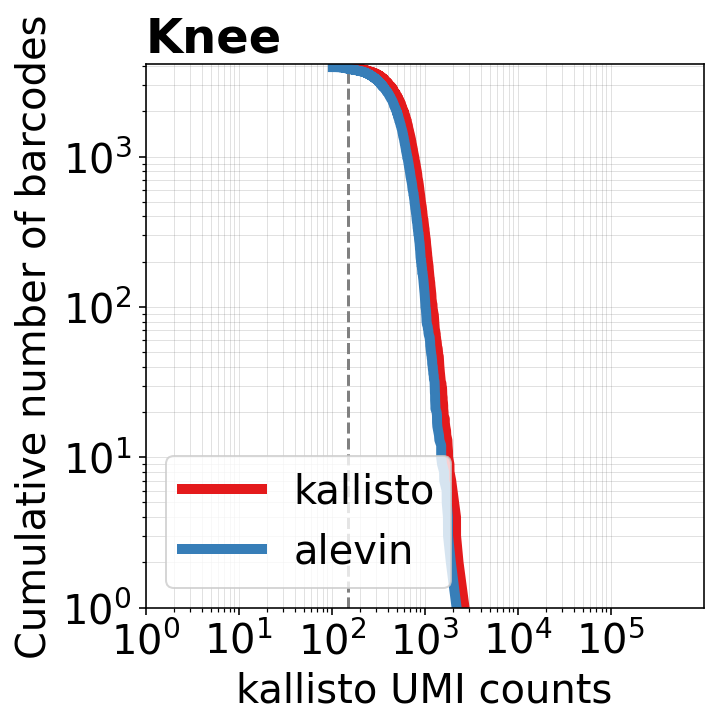

In [86]:
fig, ax = plt.subplots(figsize=(5,5))


x = np.sort(nd(kb_common_cr.X.sum(axis=1)))[::-1]
y = np.arange(x.shape[0])

ax.plot(x, y, color=kallisto_color, label="kallisto", linewidth=linewidth)
cutoff = min(x)
cutoff_mask = x>=cutoff
ax.axvline(x=cutoff, color="grey", linestyle="--")

# ## Alevin
x = np.sort(nd(alevin_common_cr.X.sum(axis=1)))[::-1]
y = np.arange(x.shape[0])

ax.plot(x, y, color = alevin_color, label="alevin", linewidth=linewidth)

ax.set(**{
    'xscale': 'log',
    'xlim': (1, xmax),
    'ylim': 1,
    'yscale': 'log',
    'xlabel': "kallisto UMI counts",
    'ylabel': "Cumulative number of barcodes"
 })

ax.set_title('Knee', fontweight='bold', loc = 'left' )
ax.legend()

fix_ticks(ax, ['x', 'y'])

# Customize the major grid
ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)


fig.show()

In [87]:
def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

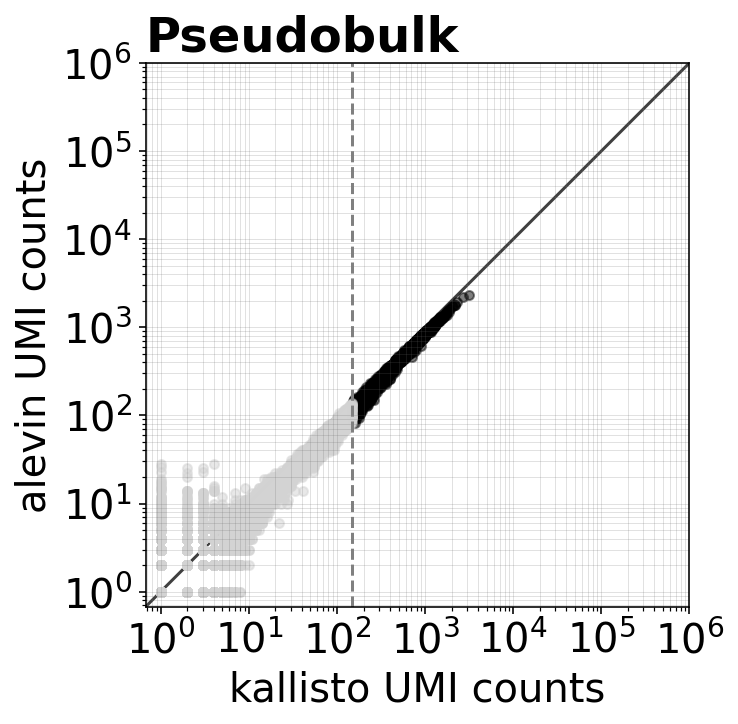

In [88]:
fig, ax = plt.subplots(figsize=(5,5))

x = kb_common.obs['counts'].values
y = alevin_common.obs['counts'].values
cutoff_mask = x>cutoff
xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, alpha = alpha-0.5, s=markersize, color="k")

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, alpha = alpha-0.5, s=markersize, color="lightgrey")


ax.axvline(x=cutoff, color="grey", linestyle="--")

ax.set(**{
    "xlim": (1, xmax),
     'xscale': 'log',
     'yscale': 'log',
    'xlabel': 'kallisto UMI counts',
    'ylabel': 'alevin UMI counts'
})
yex(ax)
fix_ticks(ax, ['x', 'y'])
ax.set_title('Pseudobulk', fontweight='bold', loc = 'left' )
ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)

fig.show()

In [89]:
import matplotlib.patches as mpatches

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


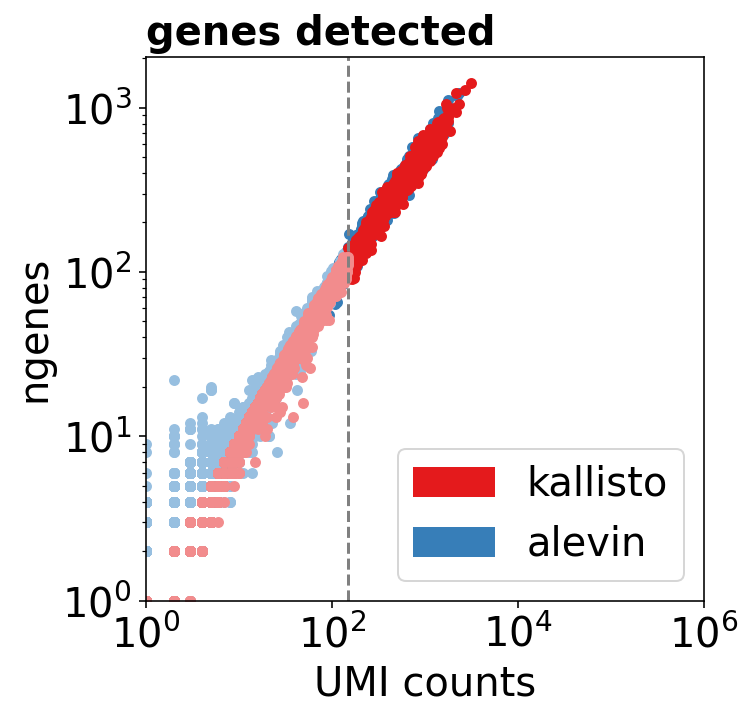

In [90]:
fig, ax = plt.subplots(figsize=(5,5))

x = kb_common.obs['counts'].values
y = kb_common.obs['ngenes'].values

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, alpha =alpha, s=markersize, label='kallisto', color=kallisto_color)

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, alpha = alpha, s=markersize, color=lighten_color(kallisto_color))

ax.axvline(x=cutoff, color="grey", linestyle="--")



x = alevin_common.obs['counts'].values
y = alevin_common.obs['ngenes'].values

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, alpha =alpha, s=markersize, label='alevin', color=alevin_color, zorder = -1)

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, alpha = alpha, s=markersize, color=lighten_color(alevin_color), zorder=-1)

ax.set(**{
    'xscale': 'log',
    'yscale': 'log',
    'xlim': (1, xmax),
    'ylim': (1),
    'xlabel': 'UMI counts',
    'ylabel': 'ngenes'
})

A_patch = mpatches.Patch(color=kallisto_color, label="kallisto")
B_patch = mpatches.Patch(color=alevin_color, label="alevin")
ax.legend(handles=[A_patch, B_patch], loc="lower right")

ax.set_title('genes detected', fontweight='bold', fontsize = fsize, loc = 'left' )


fig.show()

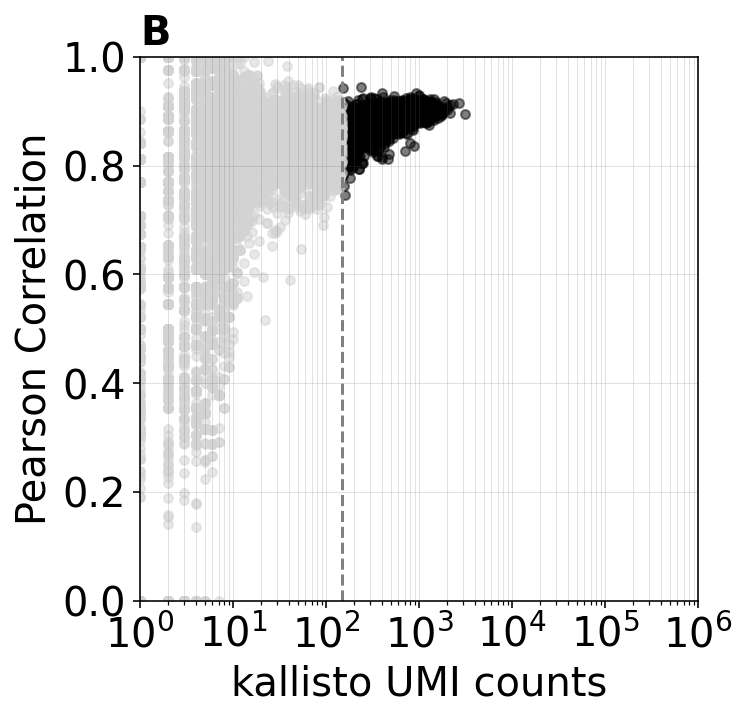

In [94]:
fig, ax = plt.subplots(figsize=(5,5))

x = kb_common.obs['counts'].values
y = cc_raw

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, s=markersize, alpha=alpha-0.5, color="k")

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, s=markersize, alpha=alpha-0.5, color="lightgray")

ax.axvline(x=cutoff, color="grey", linestyle="--")

ax.set(**{
    'xscale': 'log',
    "xlim": (1, xmax),
    'ylim': (0,1),
    'xlabel': 'kallisto UMI counts',
    'ylabel': 'Pearson Correlation'
})

ax.set_title('B', fontweight='bold', fontsize = fsize, loc = 'left' )
ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)

fix_ticks(ax, ['x'])

fig.show()

In [105]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_hist(A, B, orientation="vertical", ax=None):
    hist, concat_bins = np.histogram(np.concatenate((A,B)), bins='auto')
    hist, A_bins =  np.histogram(A, bins='auto')
    hist, B_bins =  np.histogram(B, bins='auto')

    best_bins = min([A_bins,concat_bins,B_bins], key=len) # may need to change to max
    best_bins = concat_bins
    ax.hist(A, bins=concat_bins, orientation=orientation, color=kallisto_color, label="kallisto", alpha=1,)# bins=best_bins)
    ax.hist(B, bins=concat_bins, orientation=orientation, color=alevin_color, label="alevin", alpha=1,)# bins=best_bins)
    return ax

def make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=None):
    x = dist_AA
    y = dist_AB

    xx = dist_BA
    yy = dist_BB

    # the scatter plot:
    ax.scatter(x, y, label="kallisto", color=kallisto_color)
    ax.scatter(xx, yy, label="alevin", color=alevin_color)
#    ax.set(**{'yscale': 'log', 'xscale':'log'})
    ax.set_aspect(1.)

    # create new axes on the right and on the top of the current axes
    # The first argument of the new_vertical(new_horizontal) method is
    # the height (width) of the axes to be created in inches.
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", 1.5, pad=0.075, sharex=ax)
    axHisty = divider.append_axes("right", 1.5, pad=0.075, sharey=ax)

    # make some labels invisible
    axHistx.xaxis.set_tick_params(labelbottom=False)
    axHisty.yaxis.set_tick_params(labelleft=False)


    ## Right histogram,  cellranger-cellranger, kallisto-cellranger,
    axHisty = make_hist(y, yy, orientation="horizontal", ax=axHisty)

    # kallisto-kallisto, cellranger-kallisto
    axHistx = make_hist(x, xx, orientation="vertical", ax=axHistx)


    # the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
    # thus there is no need to manually adjust the xlim and ylim of these
    # axis.
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_xlabel("$\ell_1$ to nearest kallisto", fontsize=fsize)
    ax.set_ylabel("$\ell_1$ to nearest alevin", fontsize=fsize)
    axHistx.set_ylabel("Barcode counts", fontsize=fsize-8)
    axHisty.set_xlabel("Barcode counts", fontsize=fsize-8)

    axHistx.legend(fontsize=fsize-5, loc="upper right")
    return axHistx

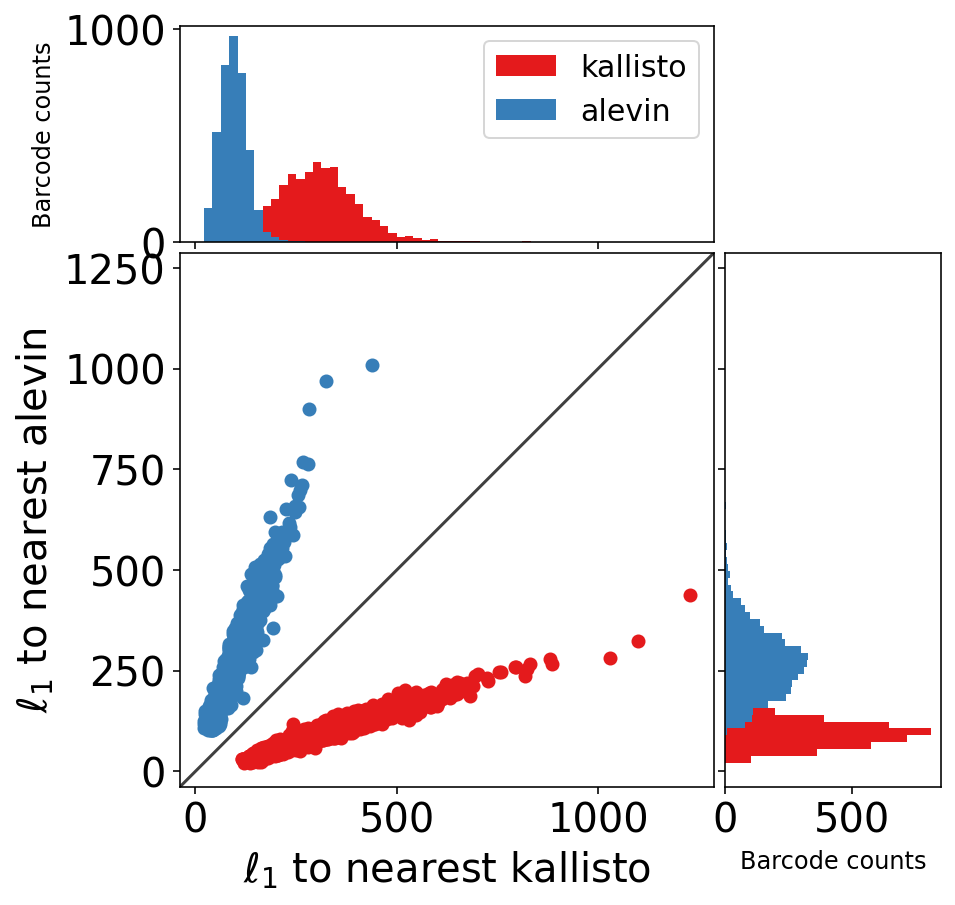

In [106]:
fig, ax = plt.subplots(figsize=(7,7))

make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=ax)

fig.show()

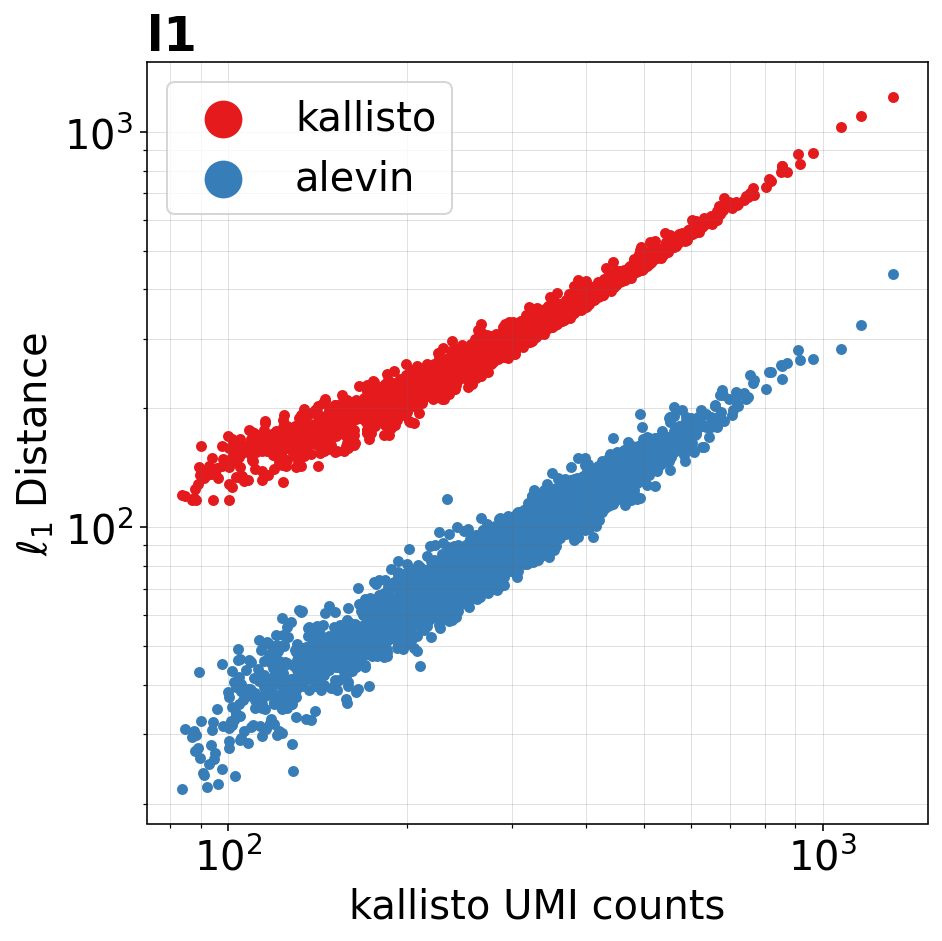

In [126]:
fig, ax = plt.subplots(figsize=(7,7))

title = "l1"

cnts = nd(kb_common_cr.layers["log1p"].sum(1))

ax.scatter(cnts, dist_AA, color=kallisto_color, alpha=alpha, label="kallisto", s=markersize)
ax.scatter(cnts, dist_AB, color=alevin_color, alpha=alpha, label="alevin", s=markersize)

ax.set(**{
    "xlabel": "kallisto UMI counts",
    "ylabel": "$\ell_1$ Distance",
    'xscale': 'log',
    'yscale': 'log',
#    'xlim': (1, xmax)
})

ax.set_title(title, fontweight='bold', loc = 'left' )

#A_patch = mpatches.Patch(color=kallisto_color, label="kallisto")
#B_patch = mpatches.Patch(color=alevin_color, label="alevin")
#ax.legend(handles=[A_patch, B_patch], loc="upper left")
ax.legend(markerscale=4, loc='upper left')

fix_ticks(ax)
ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)


fig.show()

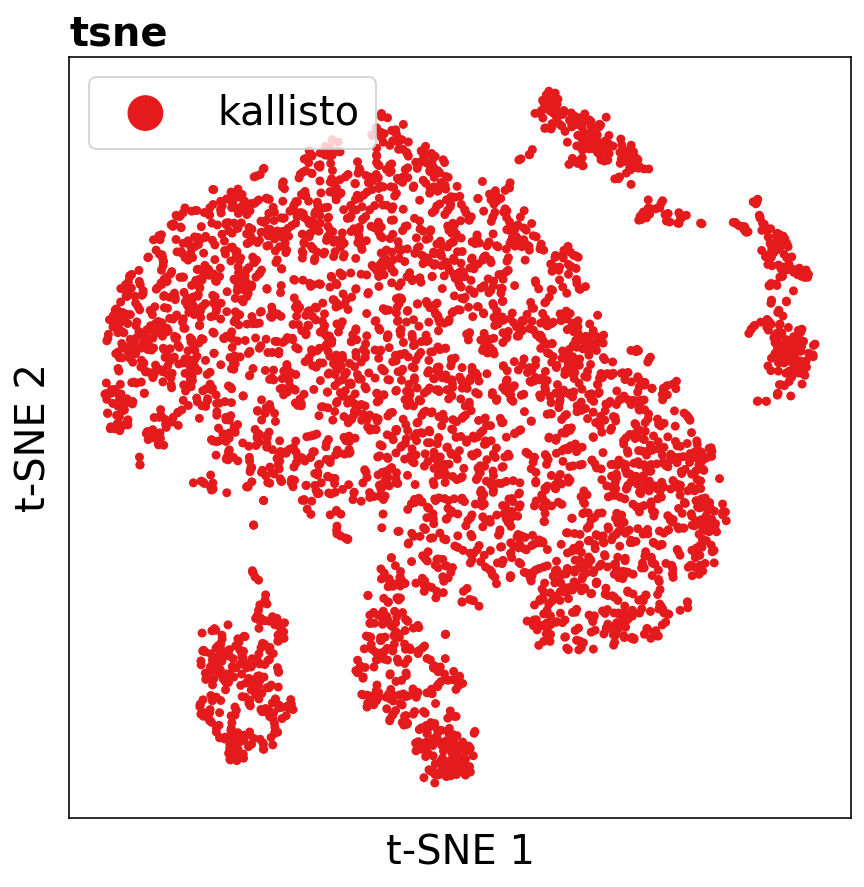

In [40]:
fig, ax = plt.subplots(figsize=(7,7))

title = "tsne"

label = "kallisto"
color = kallisto_color
x = kb_common_cr.obsm['TSNE'][:,0]
y = kb_common_cr.obsm['TSNE'][:,1]

ax.scatter(x, y, s =markersize, c = color, alpha = 1, edgecolors = 'none', label = label)

ax.set(**{
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
    "xticklabels": [],
    "yticklabels": [],
    
})

ax.set_title(title, fontweight='bold', fontsize = fsize, loc = 'left' )
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.legend(fontsize=fsize, markerscale=4, loc="upper left")

fig.show()

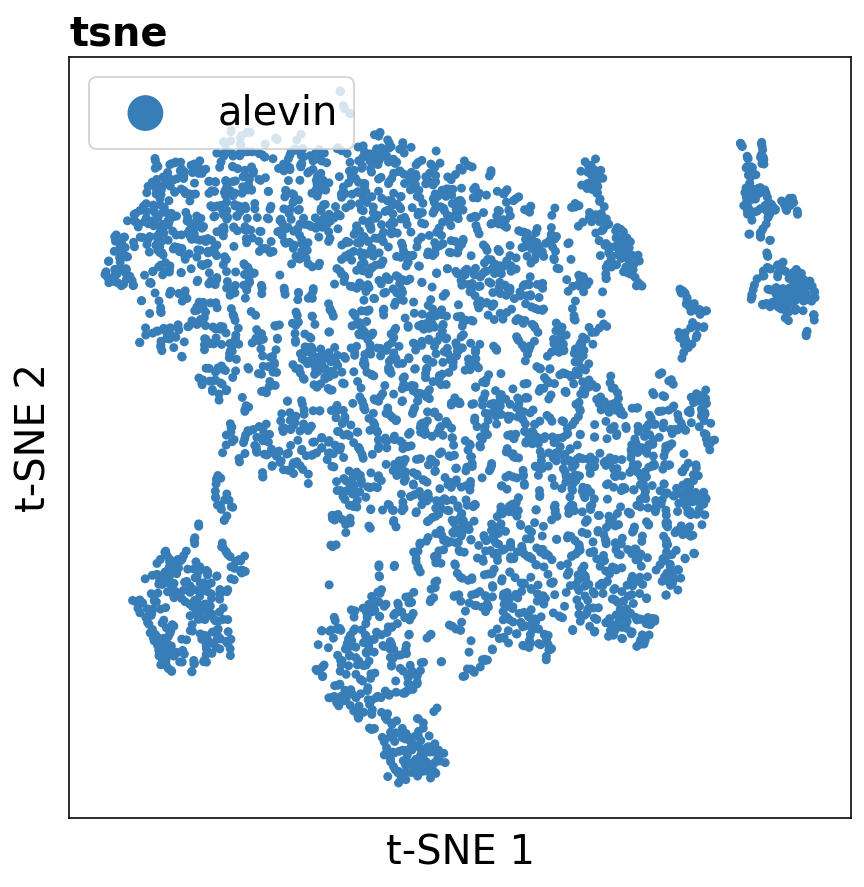

In [41]:
fig, ax = plt.subplots(figsize=(7,7))

title = "tsne"

label = "alevin"
color = alevin_color

x = alevin_common_cr.obsm['TSNE'][:,0]
y = alevin_common_cr.obsm['TSNE'][:,1]

ax.scatter(x, y, s =markersize, c = color, alpha = 1, edgecolors = 'none', label = label)

ax.set(**{
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
    "xticklabels": [],
    "yticklabels": [],
    
})

ax.set_title(title, fontweight='bold', fontsize = fsize, loc = 'left' )
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.legend(fontsize=fsize, markerscale=4, loc="upper left")

fig.show()

In [42]:
def _plt_color(lst):
    cols=[]
    for l in lst:
        if l>0.25 or l<-0.25:
            cols.append("red")
        elif l<=0.25 and l>=-0.25:
            cols.append('black')
    return cols

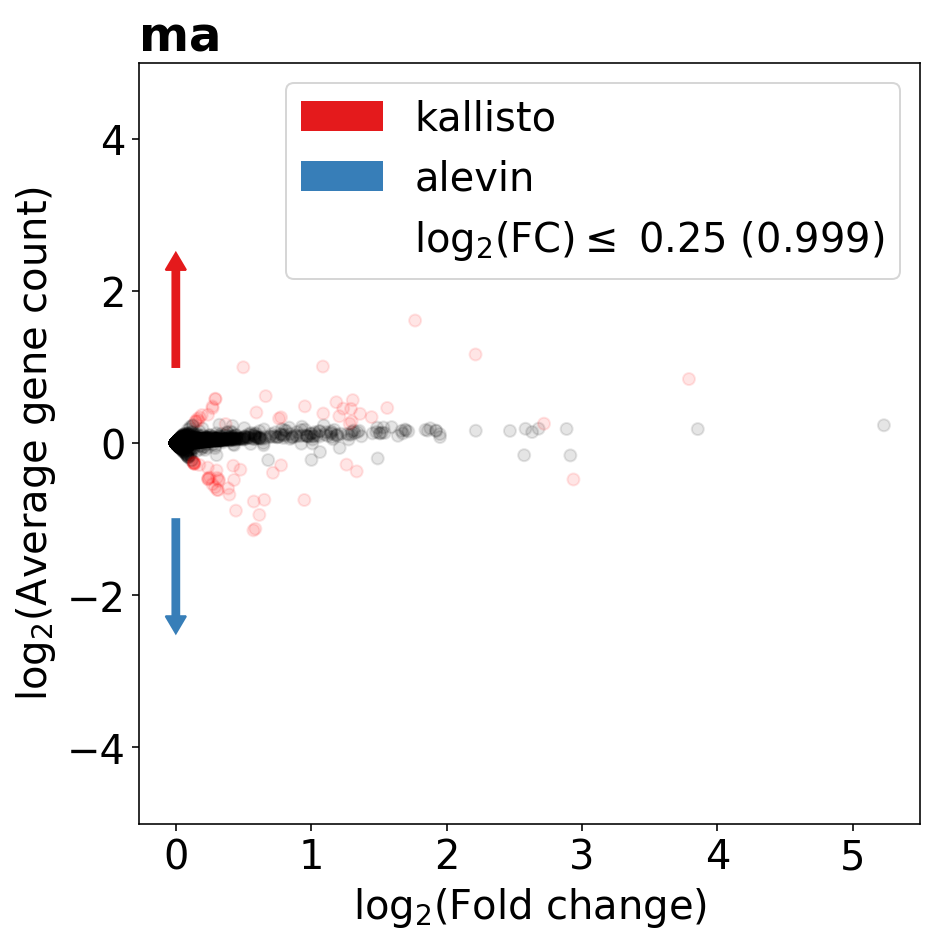

In [43]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(7,7))

title = "ma"

cols = _plt_color(M_AB)
ax.scatter(A_AB, M_AB, alpha=0.1, c=cols)

ax.set(**{
    "xlabel": "log$_2$(Fold change)",
    "ylabel": "log$_2$(Average gene count)",
    "ylim": (-5, 5)
})


ax.set_title(title, fontweight='bold', loc = 'left' )

A_patch = mpatches.Patch(color=kallisto_color, label="kallisto")
B_patch = mpatches.Patch(color=alevin_color, label="alevin")
same = mpatches.Patch(color='white', label='log$_2$(FC)$\leq$ 0.25 ({:.3f})'.format(M_AB[M_AB<=0.25].shape[0]/M_AB.shape[0]))
ax.arrow(0, 1, 0, 1.5, length_includes_head=True, width=.05, color=kallisto_color)
ax.arrow(0, -1, 0, -1.5, length_includes_head=True, width=.05, color=alevin_color)
ax.legend(handles=[A_patch, B_patch, same], fontsize=fsize, loc="upper right")

fig.show()

## QQ plot

In [44]:
def QQ_hgmm(path, ax):
    dataset_shortname = os.path.basename(path).split(".")[0]
    df = pd.read_csv(path)
    df.ontology = df.ontology.astype("category")

    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()

    from matplotlib.lines import Line2D
    hg = df[df.mapping.str.contains("Hs")]
    mm = df[df.mapping.str.contains("Mm")]
    legend_elements = [Line2D([0], [0], marker='o', color="w",alpha=0.4, label='Human',markerfacecolor='k', markersize=10),
                      Line2D([0], [0], marker='s', color='w', alpha=0.2, label='Mouse', markerfacecolor='grey', markersize=10)]

    #c = le.fit_transform(df.ontology.values)

    c = le.fit_transform(hg.ontology.values)
    scatter = ax.scatter(hg.uniform_log, hg.p_log, c=c)

    c = le.fit_transform(mm.ontology.values)
    ax.scatter(mm.uniform_log, mm.p_log, c=c, marker='s')

    l1 = ax.legend(handles=legend_elements, loc="lower right", title="Species", fontsize=fsize-5, title_fontsize=fsize-5)

    ax.plot(hg.uniform_log, hg.upper, color='k', alpha=0)
    ax.plot(hg.uniform_log, hg.lower, color='k', alpha=0)

    ax.plot(mm.uniform_log, mm.upper, color='grey', alpha=0)
    ax.plot(mm.uniform_log, mm.lower, color='grey', alpha=0)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.fill_between(hg.uniform_log, hg.lower, hg.upper, color='black', alpha='0.4')
    ax.fill_between(mm.uniform_log, mm.lower, mm.upper, color='grey', alpha='0.2')



    # Produce a legend for the ranking (colors). Even though there are 40 different
    # rankings, we only want to show 5 of them in the legend.

    l2 = ax.legend(*(scatter.legend_elements()[0], le.classes_), loc="upper left", title="Ontology", fontsize=fsize-5, title_fontsize=fsize-5)
    ax.add_artist(l1)


    ax.set_xlabel("Expected -log$_{10}$(p)", fontsize=fsize)
    ax.set_ylabel("Observed -log$_{10}$(p)", fontsize=fsize)
    df = df[df.label.astype(str).values != 'nan']
    base = os.path.dirname(path)
    with open(os.path.join(base, f"GO_{dataset_shortname}.txt"), 'w') as f:


        for i, txt in enumerate(df["rank"]):
            f.write(str(i+1) + "\t" + df.label.values[i] + "\n")
            print(df.label.values[i])
            ax.annotate(txt, (df.uniform_log[i], df.p_log[i]), fontsize=15)
    ax.set_title("QQ", fontweight='bold', fontsize = fsize, loc = 'left' )
    return ax

def QQ_plot(path, ax):
    dataset_shortname = os.path.basename(path).split(".")[0]
    
    if "mm" in dataset_shortname:
        return QQ_hgmm(path, ax)
    
    df = pd.read_csv(path)
    df.ontology = df.ontology.astype("category")

    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()


    c = le.fit_transform(df.ontology.values)

    scatter = ax.scatter(df.uniform_log, df.p_log, c=c)


    ax.plot(df.uniform_log, df.upper, color='k', alpha=0)
    ax.plot(df.uniform_log, df.lower, color='k', alpha=0)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.fill_between(df.uniform_log, df.lower, df.upper, color='black', alpha=0.4)

    # Produce a legend for the ranking (colors). Even though there are 40 different
    # rankings, we only want to show 5 of them in the legend.

    l2 = ax.legend(*(scatter.legend_elements()[0], le.classes_), loc="best", title="Ontology", fontsize=fsize-5, title_fontsize=fsize-5)


    ax.set_xlabel("Expected -log$_{10}$(p)", fontsize=fsize)
    ax.set_ylabel("Observed -log$_{10}$(p)", fontsize=fsize)
    df = df[df.label.astype(str).values != 'nan']
    base = os.path.dirname(path)
    with open(os.path.join(base, f"GO_{dataset_shortname}.txt"), 'w') as f:


        for i, txt in enumerate(df["rank"]):
            f.write(str(i+1) + "\t" + df.label.values[i] + "\n")
            print(df.label.values[i])
            ax.annotate(txt, (df.uniform_log[i], df.p_log[i]), fontsize=15)
    ax.set_title("QQ", fontweight='bold', fontsize = fsize, loc = 'left' )
    return ax

/home/sina/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/sina/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/sina/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


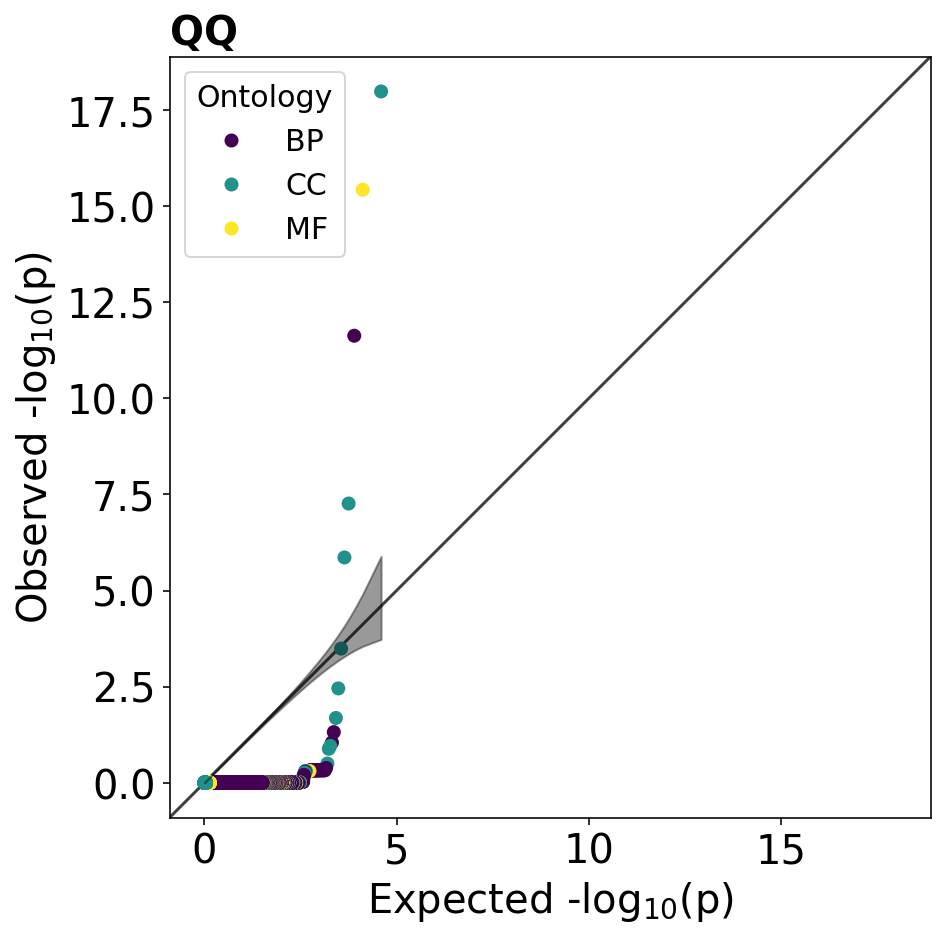

In [45]:
fig, ax = plt.subplots(figsize=(7,7))

QQ_plot(f"../../data/gsea_qq/{ds}.csv", ax)

fig.show()

## DE plot

In [115]:
def DE_plot(bar_path, go_terms_path, ax=None):


    fold_change_change_colors = {
    '(4,5]': lighten_color(kallisto_color, 1.4),
    '(3,4]': lighten_color(kallisto_color, 1.1),
    '(2,3]': lighten_color(kallisto_color, 0.8),
    '(1,2]': lighten_color(kallisto_color, 0.5),
    '(0,1]': lighten_color(kallisto_color, 0.2),
    '(-1,0]': lighten_color(alevin_color, 0.2),
    '(-2,-1]':lighten_color(alevin_color, 0.5),
    '(-3,-2]':lighten_color(alevin_color, 0.8),
    '(-4,-3]':lighten_color(alevin_color, 1.1),
    '(-5,-4]':lighten_color(alevin_color, 1.4),
    }
    
    df = pd.read_csv(bar_path)
    go = pd.read_csv(go_terms_path)
    go.index = go['GO.ID']

    df['Term'] = df['GO.ID'].map(go['GO_full_name']).astype(str)

    # For some datasets there are no DE genes, so we need this check to just write a text and make not plot
    df = df[~df.Term.str.contains('nan')]
    genesets = np.sort(df.Term.unique())
    
    if len(genesets)==0:
        ax.text(0.5*(1), 0.5*(1), 'No significant gene sets found ',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=20, color='black',
            transform=ax.transAxes)
        ax.axis('off')

    # If there are DE genes, then we make a plot
    elif len(genesets)>0:
        gb = (df.groupby(["change", "Term"])[['gene']].nunique())
        new_df = gb.unstack(fill_value=0).sort_index(level=0, key=lambda x: [int(i[1:].split(',')[0]) for i in x])['gene']

        itvs = new_df.index.values
        names = new_df.columns.values
        mtx = new_df.values

        ind = np.arange(names.shape[0])
        bottom = np.zeros_like(names)

        for itv, row in zip(itvs, mtx):
            ax.bar(ind, row, bottom = bottom, label = itv,
                    alpha = 0.5, width=0.8, color = fold_change_change_colors[itv])
            bottom+= row

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], title='Fold change')

        labels = [i.replace(" ", "\n") for i in names]

        ax.set(**{
            "xticks": ind,
            "ylabel": "Number of genes",
            "xlabel": "Gene set"
        })
        ax.set_xticklabels(labels, fontsize=10)

        for label in ax.get_xmajorticklabels():
            label.set_horizontalalignment("center")

        ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = 0.5)
    ax.set_title('gsea', fontweight='bold')
    return ax

In [116]:
bar_path = f"../../data/gsea_bar/{ds}.csv"
go_terms_path =  "../../reference/GO/go_defMus_musculus.csv"

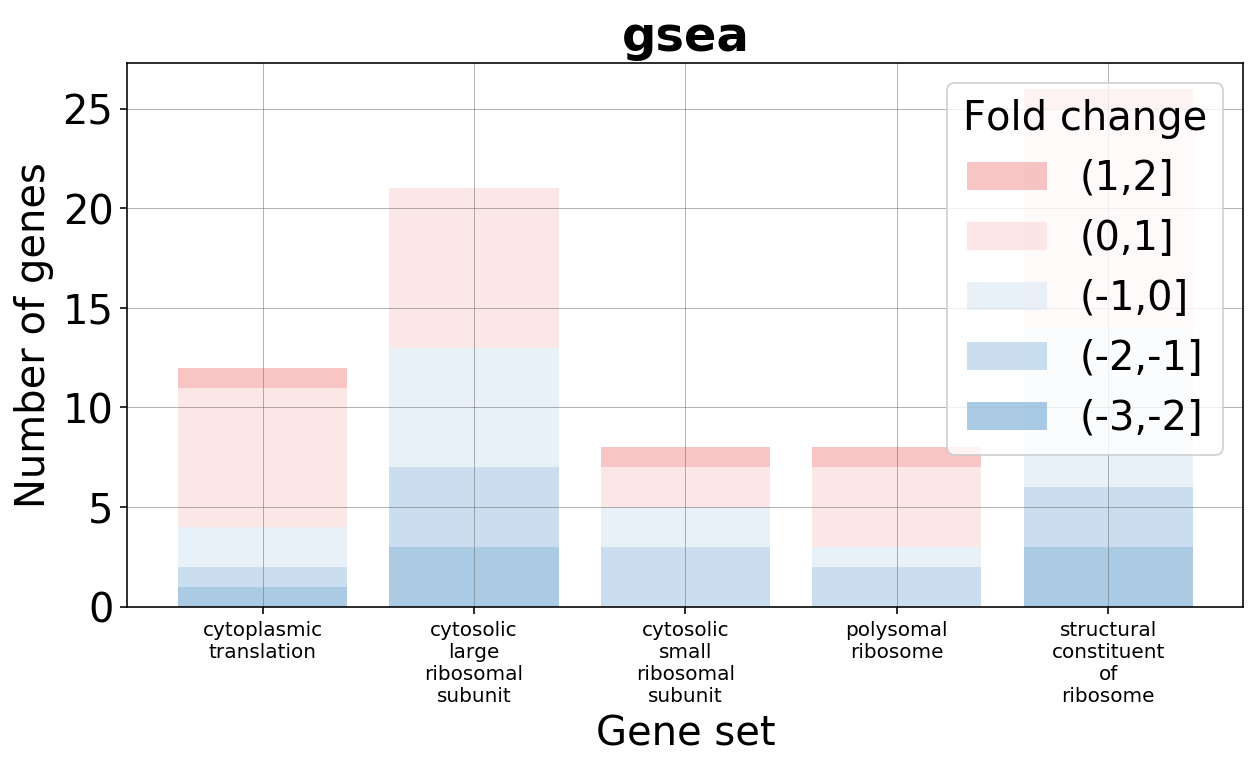

In [117]:
fig, ax = plt.subplots(figsize=(10,5))

DE_plot(bar_path, go_terms_path, ax=ax)

fig.show()

# All together

In [122]:
def _plt_color(lst):
    cols=[]
    for l in lst:
        if l>0.25 or l<-0.25:
            cols.append("red")
        elif l<=0.25 and l>=-0.25:
            cols.append('black')
    return cols

import matplotlib.patches as mpatches

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_hist(A, B, orientation="vertical", ax=None):
    hist, concat_bins = np.histogram(np.concatenate((A,B)), bins='auto')
    hist, A_bins =  np.histogram(A, bins='auto')
    hist, B_bins =  np.histogram(B, bins='auto')

    best_bins = min([A_bins,concat_bins,B_bins], key=len) # may need to change to max

    ax.hist(A, bins=best_bins, orientation=orientation, color=kallisto_color, label="kallisto", alpha=1)
    ax.hist(B, bins=best_bins, orientation=orientation, color=alevin_color, label="alevin", alpha=1)
    return ax

def make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=None):
    x = dist_AA
    y = dist_AB

    xx = dist_BA
    yy = dist_BB

    # the scatter plot:
    ax.scatter(x, y, label="kallisto", color=kallisto_color, s=markersize)
    ax.scatter(xx, yy, label="alevin", color=alevin_color, s=markersize)
    ax.set_aspect(1.)

    # create new axes on the right and on the top of the current axes
    # The first argument of the new_vertical(new_horizontal) method is
    # the height (width) of the axes to be created in inches.
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", 1.5, pad=0.075, sharex=ax)
    axHisty = divider.append_axes("right", 1.5, pad=0.075, sharey=ax)

    # make some labels invisible
    axHistx.xaxis.set_tick_params(labelbottom=False)
    axHisty.yaxis.set_tick_params(labelleft=False)


    ## Right histogram,  cellranger-cellranger, kallisto-cellranger,
    axHisty = make_hist(y, yy, orientation="horizontal", ax=axHisty)

    # kallisto-kallisto, cellranger-kallisto
    axHistx = make_hist(x, xx, orientation="vertical", ax=axHistx)


    # the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
    # thus there is no need to manually adjust the xlim and ylim of these
    # axis.
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_xlabel("$\ell_1$ to nearest kallisto", fontsize=fsize)
    ax.set_ylabel("$\ell_1$ to nearest alevin", fontsize=fsize)
    axHistx.set_ylabel("Barcode counts", fontsize=fsize-8)
    axHisty.set_xlabel("Barcode counts", fontsize=fsize-8)

    axHistx.set_title("$\ell_1$ distance", fontweight='bold', loc = 'left' )

    axHistx.legend(fontsize=fsize-5, loc="upper right")
    return axHistx

def QQ_hgmm(path, ax):
    dataset_shortname = os.path.basename(path).split(".")[0]
    df = pd.read_csv(path)
    df.ontology = df.ontology.astype("category")

    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()

    from matplotlib.lines import Line2D
    hg = df[df.mapping.str.contains("Hs")]
    mm = df[df.mapping.str.contains("Mm")]
    legend_elements = [Line2D([0], [0], marker='o', color="w",alpha=0.4, label='Human',markerfacecolor='k', markersize=10),
                      Line2D([0], [0], marker='s', color='w', alpha=0.2, label='Mouse', markerfacecolor='grey', markersize=10)]

    #c = le.fit_transform(df.ontology.values)

    c = le.fit_transform(hg.ontology.values)
    scatter = ax.scatter(hg.uniform_log, hg.p_log, c=c)

    c = le.fit_transform(mm.ontology.values)
    ax.scatter(mm.uniform_log, mm.p_log, c=c, marker='s')

    l1 = ax.legend(handles=legend_elements, loc="lower right", title="Species", fontsize=fsize-5, title_fontsize=fsize-5)

    ax.plot(hg.uniform_log, hg.upper, color='k', alpha=0)
    ax.plot(hg.uniform_log, hg.lower, color='k', alpha=0)

    ax.plot(mm.uniform_log, mm.upper, color='grey', alpha=0)
    ax.plot(mm.uniform_log, mm.lower, color='grey', alpha=0)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.fill_between(hg.uniform_log, hg.lower, hg.upper, color='black', alpha='0.4')
    ax.fill_between(mm.uniform_log, mm.lower, mm.upper, color='grey', alpha='0.2')



    # Produce a legend for the ranking (colors). Even though there are 40 different
    # rankings, we only want to show 5 of them in the legend.

    l2 = ax.legend(*(scatter.legend_elements()[0], le.classes_), loc="upper left", title="Ontology", fontsize=fsize-5, title_fontsize=fsize-5)
    ax.add_artist(l1)


    ax.set_xlabel("Expected -log$_{10}$(p)", fontsize=fsize)
    ax.set_ylabel("Observed -log$_{10}$(p)", fontsize=fsize)
    df = df[df.label.astype(str).values != 'nan']
    ax.set_title("QQ", fontweight='bold', fontsize = fsize, loc = 'left' )
    return ax

def QQ_plot(path, ax):
    dataset_shortname = os.path.basename(path).split(".")[0]
    
    if "mm" in dataset_shortname:
        return QQ_hgmm(path, ax)
    
    df = pd.read_csv(path)
    df.ontology = df.ontology.astype("category")

    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()


    c = le.fit_transform(df.ontology.values)

    scatter = ax.scatter(df.uniform_log, df.p_log, c=c)


    ax.plot(df.uniform_log, df.upper, color='k', alpha=0)
    ax.plot(df.uniform_log, df.lower, color='k', alpha=0)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.fill_between(df.uniform_log, df.lower, df.upper, color='black', alpha=0.4)

    # Produce a legend for the ranking (colors). Even though there are 40 different
    # rankings, we only want to show 5 of them in the legend.

    l2 = ax.legend(*(scatter.legend_elements()[0], le.classes_), loc="best", title="Ontology", fontsize=fsize-5, title_fontsize=fsize-5)


    ax.set_xlabel("Expected -log$_{10}$(p)", fontsize=fsize)
    ax.set_ylabel("Observed -log$_{10}$(p)", fontsize=fsize)
    df = df[df.label.astype(str).values != 'nan']
    base = os.path.dirname(path)
    with open(os.path.join(base, f"GO_{dataset_shortname}.txt"), 'w') as f:


        for i, txt in enumerate(df["rank"]):
            f.write(str(i+1) + "\t" + df.label.values[i] + "\n")
            print(df.label.values[i])
            ax.annotate(txt, (df.uniform_log[i], df.p_log[i]), fontsize=15)
    return ax

def DE_plot(bar_path, go_terms_path, ax=None):


    fold_change_change_colors = {
    '(4,5]': lighten_color(kallisto_color, 1.4),
    '(3,4]': lighten_color(kallisto_color, 1.1),
    '(2,3]': lighten_color(kallisto_color, 0.8),
    '(1,2]': lighten_color(kallisto_color, 0.5),
    '(0,1]': lighten_color(kallisto_color, 0.2),
    '(-1,0]': lighten_color(alevin_color, 0.2),
    '(-2,-1]':lighten_color(alevin_color, 0.5),
    '(-3,-2]':lighten_color(alevin_color, 0.8),
    '(-4,-3]':lighten_color(alevin_color, 1.1),
    '(-5,-4]':lighten_color(alevin_color, 1.4),
    }
    
    df = pd.read_csv(bar_path)
    go = pd.read_csv(go_terms_path)
    go.index = go['GO.ID']

    df['Term'] = df['GO.ID'].map(go['GO_full_name']).astype(str)

    # For some datasets there are no DE genes, so we need this check to just write a text and make not plot
    df = df[~df.Term.str.contains('nan')]
    genesets = np.sort(df.Term.unique())
    
    if len(genesets)==0:
        ax.text(0.5*(1), 0.5*(1), 'No significant gene sets found ',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=20, color='black',
            transform=ax.transAxes)
        ax.axis('off')

    # If there are DE genes, then we make a plot
    elif len(genesets)>0:
        gb = (df.groupby(["change", "Term"])[['gene']].nunique())
        new_df = gb.unstack(fill_value=0).sort_index(level=0, key=lambda x: [int(i[1:].split(',')[0]) for i in x])['gene']

        itvs = new_df.index.values
        names = new_df.columns.values
        mtx = new_df.values

        ind = np.arange(names.shape[0])
        bottom = np.zeros_like(names)

        for itv, row in zip(itvs, mtx):
            ax.bar(ind, row, bottom = bottom, label = itv,
                    alpha = 0.5, width=0.8, color = fold_change_change_colors[itv])
            bottom+= row

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], title='Fold change')

        labels = [i.replace(" ", "\n") for i in names]

        ax.set(**{
            "xticks": ind,
            "ylabel": "Number of genes",
            "xlabel": "Gene set"
        })
        ax.set_xticklabels(labels, fontsize=10)

        for label in ax.get_xmajorticklabels():
            label.set_horizontalalignment("center")

        ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = 0.5)
    return ax

In [120]:
markersize = 20
alpha=1
linewidth=5
xmax = 10**6

kallisto_color = "#377eb8"
alevin_color = "#dede00"

kallisto_color = "#e41a1c"
alevin_color = '#377eb8'

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
dataset_name = ds

/home/sina/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/sina/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/sina/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


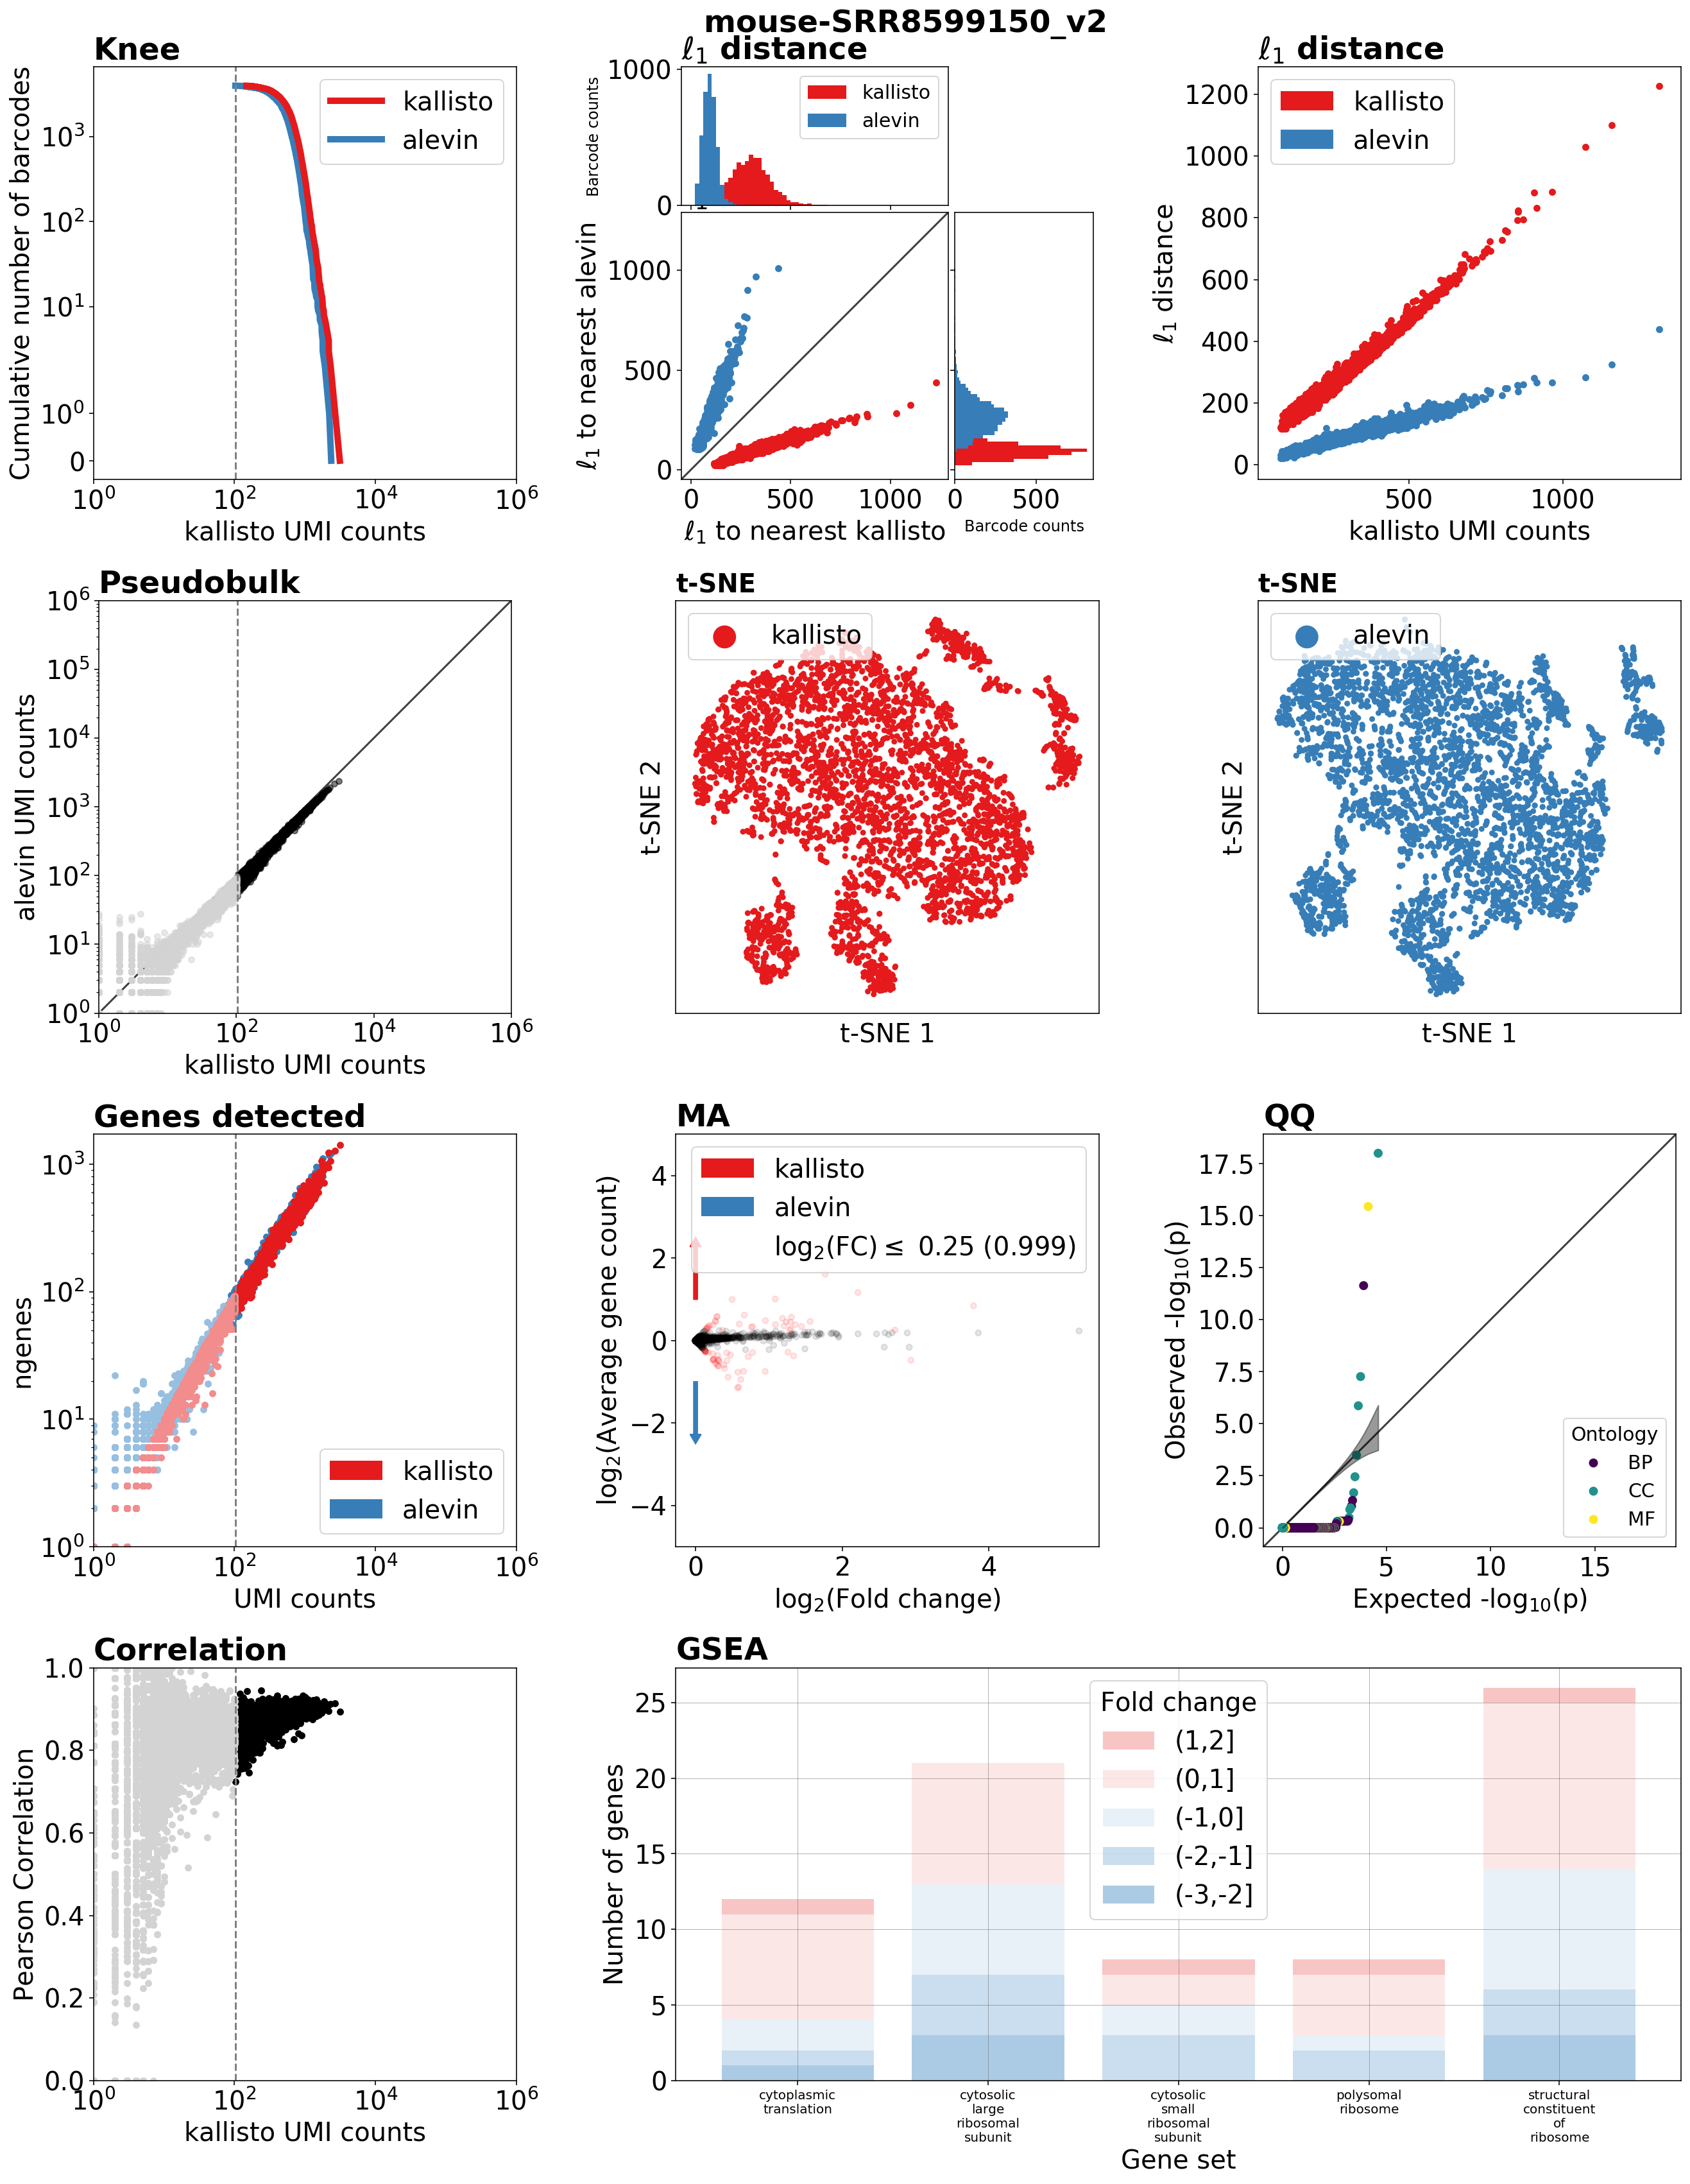

In [125]:
fig = plt.figure(figsize=(25, 25),constrained_layout=False)
st = fig.suptitle(dataset_name, fontweight='bold', x=0.4)
gs = fig.add_gridspec(8, 4)

ax_a = fig.add_subplot(gs[0:2, 0])
ax_b = fig.add_subplot(gs[2:4, 0])
ax_c = fig.add_subplot(gs[4:6, 0])
ax_d = fig.add_subplot(gs[6:8, 0])

ax_e_left   = fig.add_subplot(gs[0:2, 1])
ax_e_right  = fig.add_subplot(gs[0:2, 2])

ax_f_left   = fig.add_subplot(gs[2:4, 1])
ax_f_right  = fig.add_subplot(gs[2:4, 2])
ax_g_left   = fig.add_subplot(gs[4:6, 1])
ax_g_right  = fig.add_subplot(gs[4:6, 2])

ax_h        = fig.add_subplot(gs[6:8, 1:3])


############################################################################## KNEE plot
ax = ax_a

title = "Knee"

x = np.sort(nd(kb_common_cr.X.sum(axis=1)))[::-1]
y = np.arange(x.shape[0])

ax.plot(x, y, color=kallisto_color, label="kallisto", linewidth=linewidth)

# ## Alevin
x = np.sort(nd(alevin_common_cr.X.sum(axis=1)))[::-1]
y = np.arange(x.shape[0])

cutoff = min(x)

ax.axvline(x=cutoff, color="grey", linestyle="--")

ax.plot(x, y, color = alevin_color, label="alevin", linewidth=linewidth, zorder=-1)

ax.set(**{
    'xscale': 'log',
    'xlim': (1, xmax),
    'yscale': 'symlog',
    'xlabel': "kallisto UMI counts",
    'ylabel': "Cumulative number of barcodes"
 })
ax.set_title(title, fontweight='bold', loc = 'left' )
ax.legend()

############################################################################## PSEUDOBULK
ax = ax_b

title = "Pseudobulk"

x = kb_common.obs['counts'].values
y = alevin_common.obs['counts'].values

cutoff_mask = x>=cutoff

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, alpha = alpha-0.5, s=markersize, color="k")

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, alpha = alpha-0.5, s=markersize, color="lightgrey")


ax.axvline(x=cutoff, color="grey", linestyle="--")


ax.set(**{
    "xlim": (1, xmax),
     'xscale': 'log',
     'yscale': 'log',
    'xlabel': 'kallisto UMI counts',
    'ylabel': 'alevin UMI counts'
})
yex(ax)

ax.set_title(title, fontweight='bold', loc = 'left' )

############################################################################## GENES DETECTED
ax = ax_c

title = "Genes detected"

x = kb_common.obs['counts'].values
y = kb_common.obs['ngenes'].values

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, alpha =alpha, s=markersize, label='kallisto', color=kallisto_color)

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, alpha = alpha, s=markersize, color=lighten_color(kallisto_color))

ax.axvline(x=cutoff, color="grey", linestyle="--")

x = alevin_common.obs['counts'].values
y = alevin_common.obs['ngenes'].values

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, alpha =alpha, s=markersize, label='alevin', color=alevin_color, zorder = -1)

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, alpha = alpha, s=markersize, color=lighten_color(alevin_color), zorder=-1)

ax.set(**{
    'xscale': 'log',
    'yscale': 'log',
    'xlim': (1, xmax),
    'ylim': (1),
    'xlabel': 'UMI counts',
    'ylabel': 'ngenes'
})

A_patch = mpatches.Patch(color=kallisto_color, label="kallisto")
B_patch = mpatches.Patch(color=alevin_color, label="alevin")
ax.legend(handles=[A_patch, B_patch], loc="lower right")

ax.set_title(title, fontweight='bold', loc = 'left' )

############################################################################## CORRELATION
ax = ax_d

title = "Correlation"

x = kb_common.obs['counts'].values
y = cc_raw

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, s=markersize, alpha=alpha, color="k")

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, s=markersize, alpha=alpha, color="lightgray")

ax.axvline(x=cutoff, color="grey", linestyle="--")

ax.set(**{
    'xscale': 'log',
    "xlim": (1, xmax),
    'ylim': (0,1),
    'xlabel': 'kallisto UMI counts',
    'ylabel': 'Pearson Correlation'
})

ax.set_title(title, fontweight='bold', loc = 'left' )

############################################################################## l1
ax = ax_e_left

title = "$\ell_1$ distance"

make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=ax)

ax.set_title(title, fontweight='bold', loc = 'left' )


#############
ax = ax_e_right

title = "$\ell_1$ distance"

cnts = nd(kb_common_cr.layers["log1p"].sum(1))

ax.scatter(cnts, dist_AA, color=kallisto_color, alpha=alpha, label="kallisto", s=markersize)
ax.scatter(cnts, dist_AB, color=alevin_color, alpha=alpha, label="alevin", s=markersize)

ax.set(**{
    "xlabel": "kallisto UMI counts",
    "ylabel": "$\ell_1$ distance"
})

ax.set_title(title, fontweight='bold', loc = 'left' )

A_patch = mpatches.Patch(color=kallisto_color, label="kallisto")
B_patch = mpatches.Patch(color=alevin_color, label="alevin")
ax.legend(handles=[A_patch, B_patch], loc="upper left")

############################################################################## TSNE
ax = ax_f_left

title = "t-SNE"

label = "kallisto"
color = kallisto_color
x = kb_common_cr.obsm['TSNE'][:,0]
y = kb_common_cr.obsm['TSNE'][:,1]

ax.scatter(x, y, s =markersize, c = color, alpha = 1, edgecolors = 'none', label = label)

ax.set(**{
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
    "xticklabels": [],
    "yticklabels": [],
    
})

ax.set_title(title, fontweight='bold', fontsize = fsize, loc = 'left' )
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.legend(fontsize=fsize, markerscale=4, loc="upper left")

################
ax = ax_f_right

title = "t-SNE"

label = "alevin"
color = alevin_color

x = alevin_common_cr.obsm['TSNE'][:,0]
y = alevin_common_cr.obsm['TSNE'][:,1]

ax.scatter(x, y, s =markersize, c = color, alpha = 1, edgecolors = 'none', label = label)

ax.set(**{
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
    "xticklabels": [],
    "yticklabels": [],
    
})

ax.set_title(title, fontweight='bold', fontsize = fsize, loc = 'left' )
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.legend(fontsize=fsize, markerscale=4, loc="upper left")


############################################################################## MA
ax = ax_g_left

title = "MA"

cols = _plt_color(M_AB)
ax.scatter(A_AB, M_AB, alpha=0.1, c=cols, s=markersize)

ax.set(**{
    "xlabel": "log$_2$(Fold change)",
    "ylabel": "log$_2$(Average gene count)",
    "ylim": (-5, 5)
})


ax.set_title(title, fontweight='bold', loc = 'left' )

A_patch = mpatches.Patch(color=kallisto_color, label="kallisto")
B_patch = mpatches.Patch(color=alevin_color, label="alevin")
same = mpatches.Patch(color='white', label='log$_2$(FC)$\leq$ 0.25 ({:.3f})'.format(M_AB[M_AB<=0.25].shape[0]/M_AB.shape[0]))
ax.arrow(0, 1, 0, 1.5, length_includes_head=True, width=.05, color=kallisto_color)
ax.arrow(0, -1, 0, -1.5, length_includes_head=True, width=.05, color=alevin_color)
ax.legend(handles=[A_patch, B_patch, same], fontsize=fsize, loc="upper right")

################################################################################# QQ plot
ax = ax_g_right

title = "QQ"
QQ_plot(f"../../data/gsea_qq/{dataset_name}.csv", ax)
ax.set_title(title, fontweight='bold', loc='left')

################################################################################ GSEA Plot
ax = ax_h

REF_map = {
    "mouse": "Mus musculus",
    "human": "Homo sapiens",
    'rat': "Rattus norvegicus",
    "arabidopsis": "Arabidopsis thaliana",
    "fly": "Drosophila melanogaster",
    "worm": "Caenorhabditis elegans",
    "zebrafish": "Danio rerio",
    'human_mouse': "Homo sapiens Mus musculus"
}

species = ds.split('-')[0]
species = "_".join(REF_map.get(species).split(" "))

title = "GSEA"
DE_plot(f"../../data/gsea_bar/{ds}.csv", f"../../reference/GO/go_def{species}.csv", ax)

ax.set_title(title, fontweight='bold', loc='left')

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.925)
fig.show()